# Streamlit app dev and test



In [1]:
__author__      = 'Roy Gardner'

import networkx as nx
from networkx.readwrite import json_graph

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import csv
import sys

import ipywidgets as widgets

from scipy.spatial.distance import *


twenty_distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',\
                          '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',\
                          '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',\
                          '#000000']


In [263]:
a = ['a','b','cd']
print(a[::-1])


['cd', 'b', 'a']


In [2]:
def load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path):
    # Stash data in a dictionary
    data_dict = {}
    
    # Read the CSVs
    with open(data_path + nodes_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        nodes_header = next(reader)
        # Put the remaining rows into a list of lists
        nodes_data = [row for row in reader]

    with open(data_path + links_file, encoding='utf-8', errors='replace') as f:
        reader = csv.reader(f)
        # Get the header row
        links_header = next(reader)
        # Put the remaining rows into a list of lists
        links_data = [row for row in reader]

    with open(data_path + agreements_dict) as f:
        agreements_dict = json.load(f)
    
    # Agreement are from vertices
    agreement_vertices = list(set([row[links_header.index('from_node_id')] for row in links_data]))
    # Actors are to vertices
    actor_vertices = list(set([row[links_header.index('to_node_id')] for row in links_data]))

    edge_dict = {}
    dates_dict = {}
    for row in links_data:
        if row[5] in edge_dict:
            edge_dict[row[5]].append(row[12])
        else:
            edge_dict[row[5]] = [row[12]]
        if not row[5] in dates_dict:
            a = row[1].split('/')
            dates_dict[row[5]] = int(''.join(a[::-1]))
    
    # Build a vertices dictionary with node_id as key and node row as the value
    vertices_dict = {row[nodes_header.index('node_id')]:row for row in nodes_data}

    # Collect all vertex types
    vertex_types = []
    for k,v in vertices_dict.items():
        type_ = v[nodes_header.index('type')]
        if len(type_) == 0:
            # This type is missing in node data
            type_ = 'AGT'
        vertex_types.append(type_)
    vertex_types = sorted(list(set(vertex_types)))

    # Build a colour map for types
    color_map = {type_:twenty_distinct_colors[i] for i,type_ in enumerate(vertex_types)}
    
    # Build the agreement-actor matrix - the core data structure
    matrix = []
    for agreement in agreement_vertices:
        row = [0]*len(actor_vertices)
        for i,actor in enumerate(actor_vertices):
            if actor in edge_dict[agreement]:
                row[i] = 1
        matrix.append(row)
    matrix = np.array(matrix)
    
    data_dict['agreements_dict'] = agreements_dict
    data_dict['dates_dict'] = dates_dict
    data_dict['nodes_data'] = nodes_data
    data_dict['nodes_header'] = nodes_header
    data_dict['links_data'] = links_data
    data_dict['links_header'] = links_header
    data_dict['agreement_vertices'] = agreement_vertices
    data_dict['actor_vertices'] = actor_vertices
    data_dict['vertices_dict'] = vertices_dict
    data_dict['color_map'] = color_map
    data_dict['matrix'] = matrix

    return data_dict


(1642, 1093)
(0, 0)
[]
[]


/var/folders/hx/8yffhn597vs_58g3pjvgckn00000gn/T/ipykernel_10750/4244853020.py:82: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(pp_matrix,cmap=plt.cm.Blues)
/var/folders/hx/8yffhn597vs_58g3pjvgckn00000gn/T/ipykernel_10750/4244853020.py:82: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(pp_matrix,cmap=plt.cm.Blues)


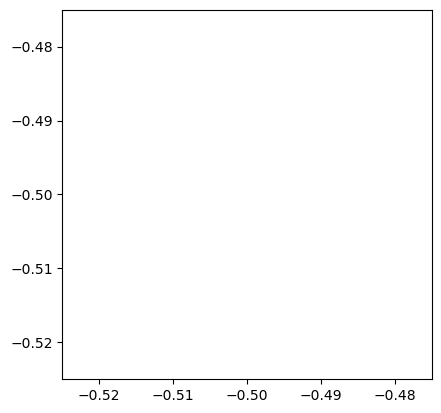

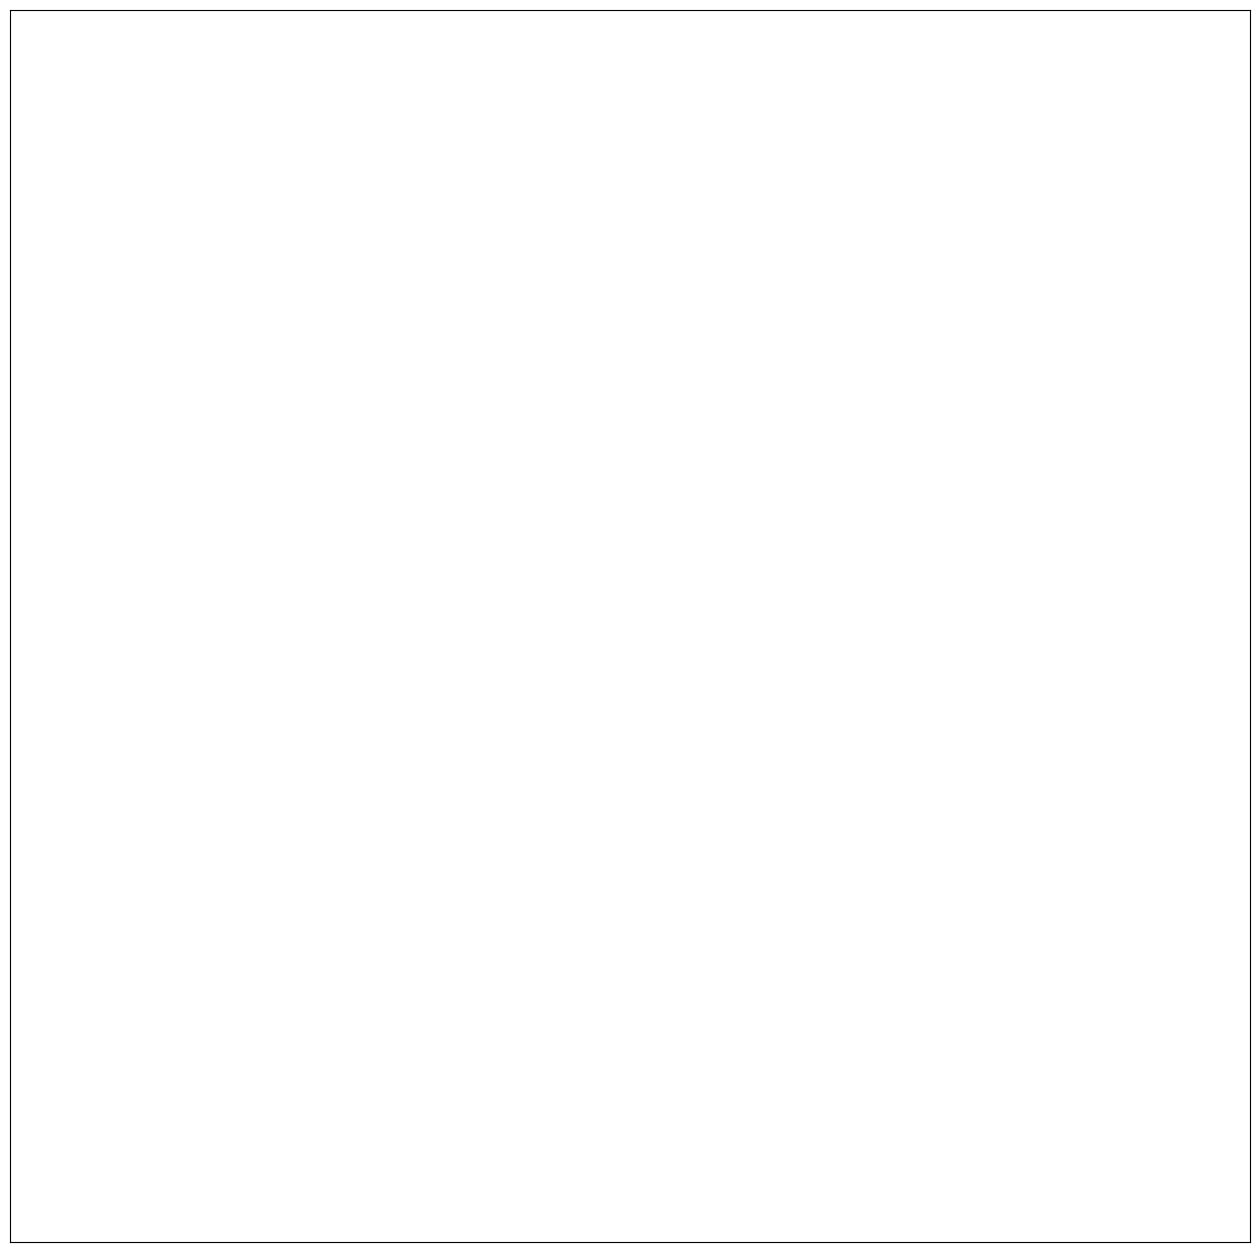

In [10]:
def get_peace_processes(data_dict):
    processes = [row[data_dict['links_header'].index('PPName')].strip() for row in data_dict['links_data']]
    return sorted(list(set(processes)))

def get_peace_process_data(process_name,data_dict):
    
    # Peace process data are in the links table so collect all edges assigned to the process
    pp_edges = [row for row in data_dict['links_data'] if row[data_dict['links_header'].\
                                                              index('PPName')].strip()==process_name]
    
    # Now we want the indices of peace process agreements and actors so we can extract the peace process
    # sub-matrix
    pp_agreement_ids = list(set([row[data_dict['links_header'].index('from_node_id')] for row in pp_edges]))
    pp_agreement_indices = [data_dict['agreement_vertices'].index(agreement_id) for\
                            agreement_id in pp_agreement_ids]
    
    pp_actor_ids = list(set([row[data_dict['links_header'].index('to_node_id')] for row in pp_edges]))
    pp_actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in pp_actor_ids]

    pp_matrix = data_dict['matrix'][np.ix_(pp_agreement_indices,pp_actor_indices)]
    pp_matrix = np.array(pp_matrix)
    pp_data_dict = {}
    pp_data_dict['pp_actor_ids'] = pp_actor_ids
    pp_data_dict['pp_agreement_ids'] = pp_agreement_ids
    pp_data_dict['pp_matrix'] = pp_matrix
    
    # Build a graph
    linked_pairs = []
    for i,row in enumerate(pp_matrix):    
        linked_pairs.extend([(pp_agreement_ids[i],v,pp_actor_ids[j]) for j,v in enumerate(row) if v > 0])
    pp_graph = nx.Graph()

    vertices = []
    vertices.extend([t[0] for t in linked_pairs if len(t[0])>0 and '_' in t[0]])
    vertices.extend([t[2] for t in linked_pairs if len(t[2])>0 and '_' in t[2]])
    vertices = list(set(vertices))

    pp_graph.add_nodes_from(vertices)
    for pair in linked_pairs:
        if len(pair[0])>0 and '_' in pair[0] and len(pair[2])>0 and '_' in pair[2]:
            pp_graph.add_edge(pair[0],pair[2],weight=pair[1])
    
    pp_data_dict['pp_graph'] = {}
    pp_data_dict['pp_graph']['graph'] = pp_graph
    pp_data_dict['pp_graph']['node_colors'] = [data_dict['color_map'][v.split('_')[0]] for v in vertices]

    return pp_data_dict

def display_graph(graph,node_colors):
    f = plt.figure(figsize=(16,16))
    pos = nx.spring_layout(graph) 
    nx.draw_networkx(graph,pos,node_color=node_colors,font_size='8',alpha=0.8)
    plt.grid(False)
    plt.show()

def get_cooccurrence_matrices(matrix):
    # Actor-actor co-occurence matrix for a peace process
    V = np.matmul(matrix.T,matrix)
    # Agreement-agreement co-occurence matrix
    W = np.matmul(matrix,matrix.T)
    return (V,W)

process_name = 'Bosnia peace process'
#process_name = 'Yemen peace process'
process_name = 'Chad: Doha Process'

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']
print(pp_matrix.shape)

print(np.matmul(pp_matrix.T,pp_matrix))
print(np.matmul(pp_matrix,pp_matrix.T))

plt.imshow(pp_matrix,cmap=plt.cm.Blues)
plt.show()

# Display graph

pp_graph = pp_data_dict['pp_graph']['graph']
node_colors = pp_data_dict['pp_graph']['node_colors']
display_graph(pp_graph,node_colors)


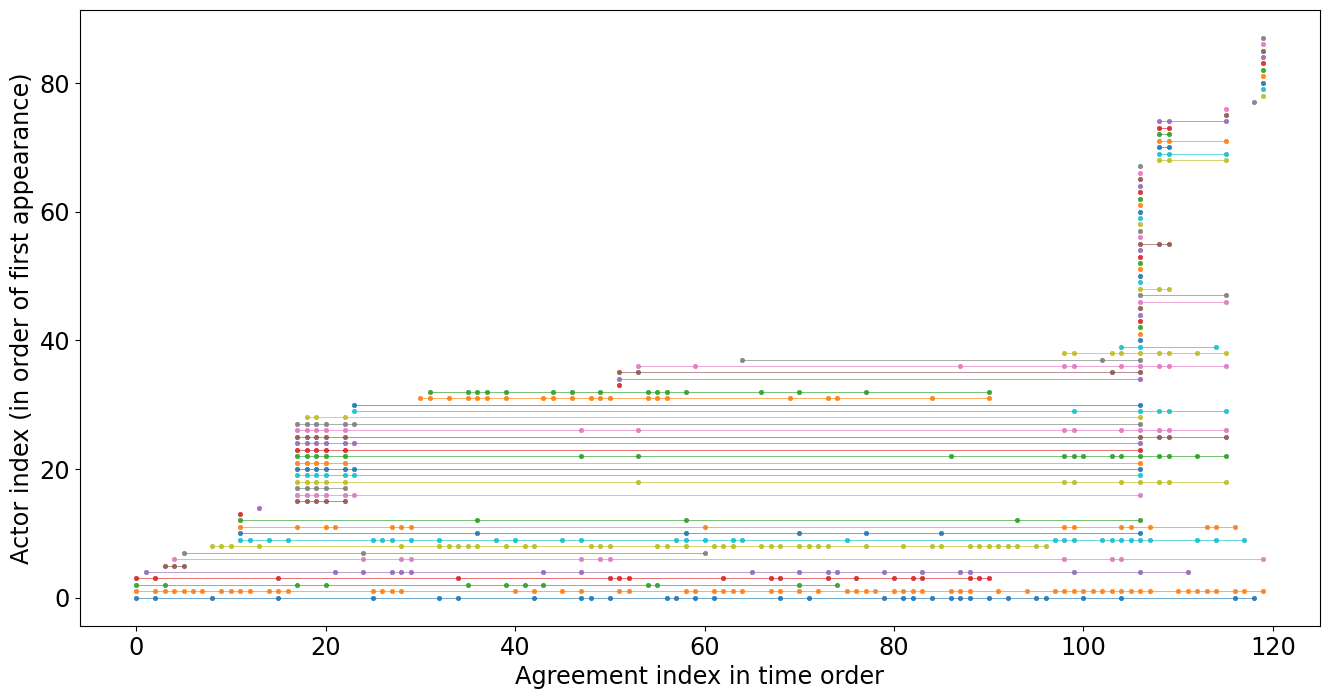

[13, 39, 76, 82, 63, 29, 84, 86, 36, 16, 33, 40, 74, 81, 50, 1, 8, 14, 27, 43, 48, 51, 53, 56, 59, 61, 70, 77, 18, 7, 66, 47, 42, 10, 12, 31, 83, 3, 60, 37, 0, 2, 4, 5, 11, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28, 30, 32, 34, 44, 45, 52, 58, 64, 65, 69, 71, 72, 80, 9, 22, 35, 41, 46, 75, 85, 62, 87, 55, 6, 38, 49, 54, 57, 67, 68, 73, 78, 79]
Finland


In [4]:
#print(data_dict['dates_dict'])

#print(pp_data_dict['pp_agreement_ids'])
pp_ag_ids = pp_data_dict['pp_agreement_ids']

t_list = []
for i,agreement_id in enumerate(pp_ag_ids):
    if not agreement_id in data_dict['dates_dict']:
        continue
    ag_date = data_dict['dates_dict'][agreement_id]
    t_list.append((i,ag_date))
# Sort by date    
t_list = sorted(t_list,key=lambda t:t[1])
    
# Build a time-order agreement-actor matrix
ordered_matrix = []
for t in t_list:
    ordered_matrix.append(pp_data_dict['pp_matrix'][t[0]])
    
ordered_matrix = np.array(ordered_matrix)
# Put actors in rows
ordered_matrix = ordered_matrix.T

# Now order actors by first appearance in process
row_indices = []
for i,row in enumerate(ordered_matrix):
    where = np.where(row==1)
    v = 0
    if len(where[0]) > 0:
        v = where[0][0]
    row_indices.append((i,v))
sorted_row_indices = [t[0] for t in sorted(row_indices,key=lambda t:t[1])]

sorted_matrix = ordered_matrix[np.ix_(sorted_row_indices)]

f = plt.figure(figsize=(16,8))
for i,row in enumerate(sorted_matrix):
    x = [j for j,x in enumerate(row) if x > 0]
    y = [i]*len(x)
    plt.scatter(x,y,alpha=0.9,linewidth=0.5,s=10)
    plt.plot(x,y,alpha=0.9,linewidth=0.5)
plt.xticks(fontsize='xx-large')    
plt.yticks(fontsize='xx-large')    
plt.ylabel('Actor index (in order of first appearance)',fontsize='xx-large')
plt.xlabel('Agreement index in time order',fontsize='xx-large')
plt.show()

print(sorted_row_indices)
print(data_dict['vertices_dict'][pp_data_dict['pp_actor_ids'][4]][5])


CON_20 China
CON_21 Russia



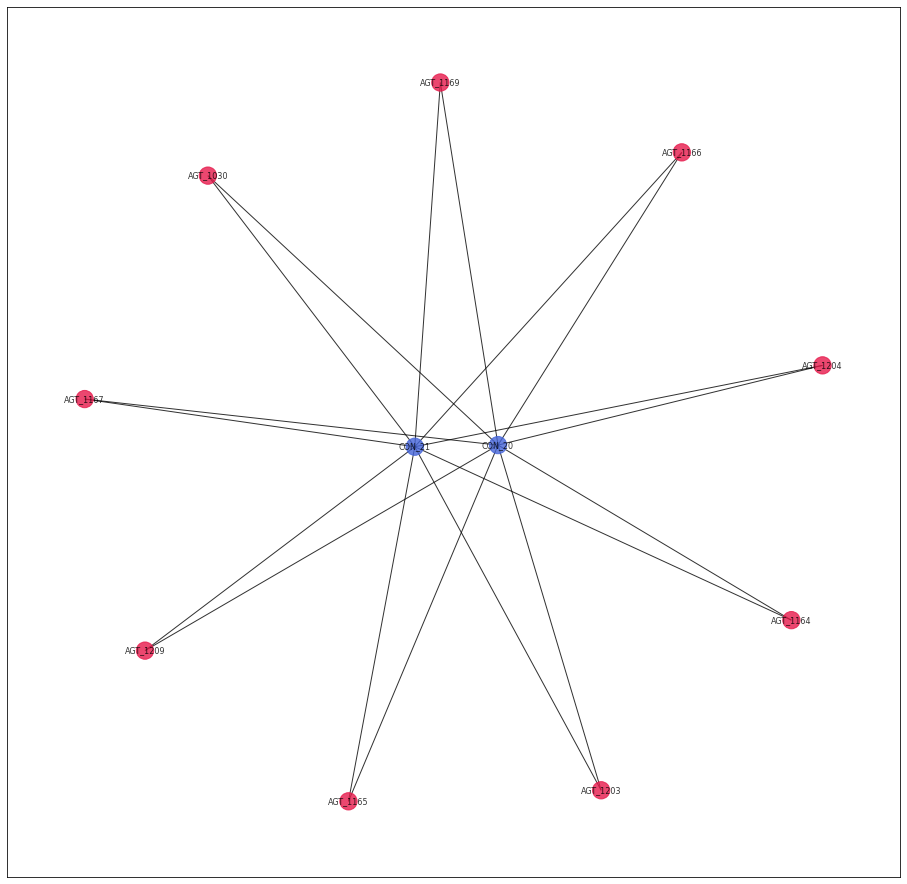

In [7]:

query_vertices = ['IGO_5','CON_2','CON_4']
query_vertices = ['IGO_5']
query_vertices = ['AGT_2']
query_vertices = ['IGO_5','CON_2','CON_3']
#query_vertices = ['NGO_201']
#query_vertices = ['CON_3','CON_19']
#query_vertices = ['CON_0']

# Dayton and conclusions
query_vertices = ['AGT_389','AGT_1030']
#query_vertices = ['AGT_1166','AGT_1169']
#query_vertices = ['AGT_2447']
query_vertices = ['CON_20','CON_21']

for vertex in query_vertices:
    print(vertex,data_dict['vertices_dict'][vertex][5])
print()

def query_graph(graph,data_dict,query_vertices=[],operator='AND',depth=1):
    tree_list = []
    for v in query_vertices:
        tree_list.append(nx.dfs_tree(graph,source=v,depth_limit=depth))

    found_vertices = set(tree_list[0].nodes) 
    for tree in tree_list:
        if operator == 'AND':
            found_vertices = found_vertices.intersection(set(tree.nodes))
        else:
            found_vertices = found_vertices.union(set(tree.nodes))

    found_vertices = list(found_vertices)    
    found_vertices.extend(query_vertices)

    found_edges = []
    for tree in tree_list:
        for e in tree.edges:
            if e[0] in found_vertices and e[1] in found_vertices:
                found_edges.append(e)

    found_graph = nx.Graph()
    found_graph.add_nodes_from(found_vertices)
    for e in found_edges:
        found_graph.add_edge(e[0],e[1],weight=1)
    node_colors = [data_dict['color_map'][v.split('_')[0]] for v in found_graph.nodes()]
    results_dict = {}
    results_dict['graph'] = found_graph
    results_dict['node_colors'] = node_colors
    return results_dict
    
process_name = 'Bosnia peace process'
data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']


pp_graph = pp_data_dict['pp_graph']['graph']

results_dict = query_graph(pp_graph,data_dict,query_vertices=query_vertices,operator='AND',depth=1)

display_graph(results_dict['graph'],results_dict['node_colors'])


## Actor diagonal by stage

In [5]:
stage_dict = {}
stage_dict['Cea'] = [1,'Ceasefire related']
stage_dict['Pre'] = [2,'Pre-negotiation process']
stage_dict['SubPar'] = [3,'Partial Framework - substantive']
stage_dict['SubComp'] = [4,'Comprehensive Framework - substantive']
stage_dict['Ren'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Imp'] = [5,'Implementation Renegotiation/Renewal']
stage_dict['Oth'] = [0,'']

# Map agreements on to stages
stage_map = {}
for i,agreement_id in enumerate(pp_data_dict['pp_agreement_ids']):
    ss_id = agreement_id.split('_')[1]
    if ss_id in data_dict['agreements_dict']:
        stage_map[i] = stage_dict[data_dict['agreements_dict'][ss_id]['Stage']][0]
    else:
        stage_map[i] = 0
    
print(len(stage_map))
print(len(pp_data_dict['pp_agreement_ids']))

print(len([v for _,v in stage_map.items() if v == 0]))


120
120
0


[('Luxembourg', 1), ('World Bank', 1), ('Finland', 1), ('Organization for Security and Cooperation in Europe', 1), ('Party of Democratic Action', 1), ('International Conference on the Former Yugoslavia', 1), ('Council of Europe', 1), ('Portugal', 1), ('North Macedonia', 1), ('Morocco', 1), ('Slovakia', 1), ('Jordan', 1), ('Ukraine', 1), ('Saudi Arabia', 1), ('Netherlands', 1), ('Sweden', 1), ('United Srpska', 1), ('Office of the United Nations High Commissioner for Human Rights', 1), ('Norway', 1), ('Our Party', 1), ('Exchange Comisssion', 1), ('International Monetary Fund', 1), ('Democratic Front', 1), ('UNMIBH', 1), ('Alliance of Independent Social Democrats', 1), ('Malaysia', 1), ('Chile', 1), ('European Bank for Reconstruction and Development', 1), ('Switzerland', 1), ('European Council', 1), ("People's European Union of Bosnia and Herzegovina", 1), ('Pakistan', 1), ('Ireland', 1), ('Slovenia', 1), ('People and Justice', 1), ('Social Democratic Party of Bosnia and Herzegovina', 1),

[('Luxembourg', 0), ('World Bank', 0), ('Finland', 0), ('Organization for Security and Cooperation in Europe', 0), ('Party of Democratic Action', 1), ('International Conference on the Former Yugoslavia', 1), ('Council of Europe', 0), ('Portugal', 0), ('North Macedonia', 0), ('Morocco', 0), ('Slovakia', 0), ('Jordan', 0), ('Ukraine', 0), ('Saudi Arabia', 0), ('Netherlands', 0), ('Sweden', 0), ('United Srpska', 1), ('Office of the United Nations High Commissioner for Human Rights', 0), ('Norway', 0), ('Our Party', 1), ('Exchange Comisssion', 0), ('International Monetary Fund', 0), ('Democratic Front', 1), ('UNMIBH', 1), ('Alliance of Independent Social Democrats', 1), ('Malaysia', 0), ('Chile', 1), ('European Bank for Reconstruction and Development', 0), ('Switzerland', 0), ('European Council', 1), ("People's European Union of Bosnia and Herzegovina", 1), ('Pakistan', 0), ('Ireland', 0), ('Slovenia', 0), ('People and Justice', 1), ('Social Democratic Party of Bosnia and Herzegovina', 1),

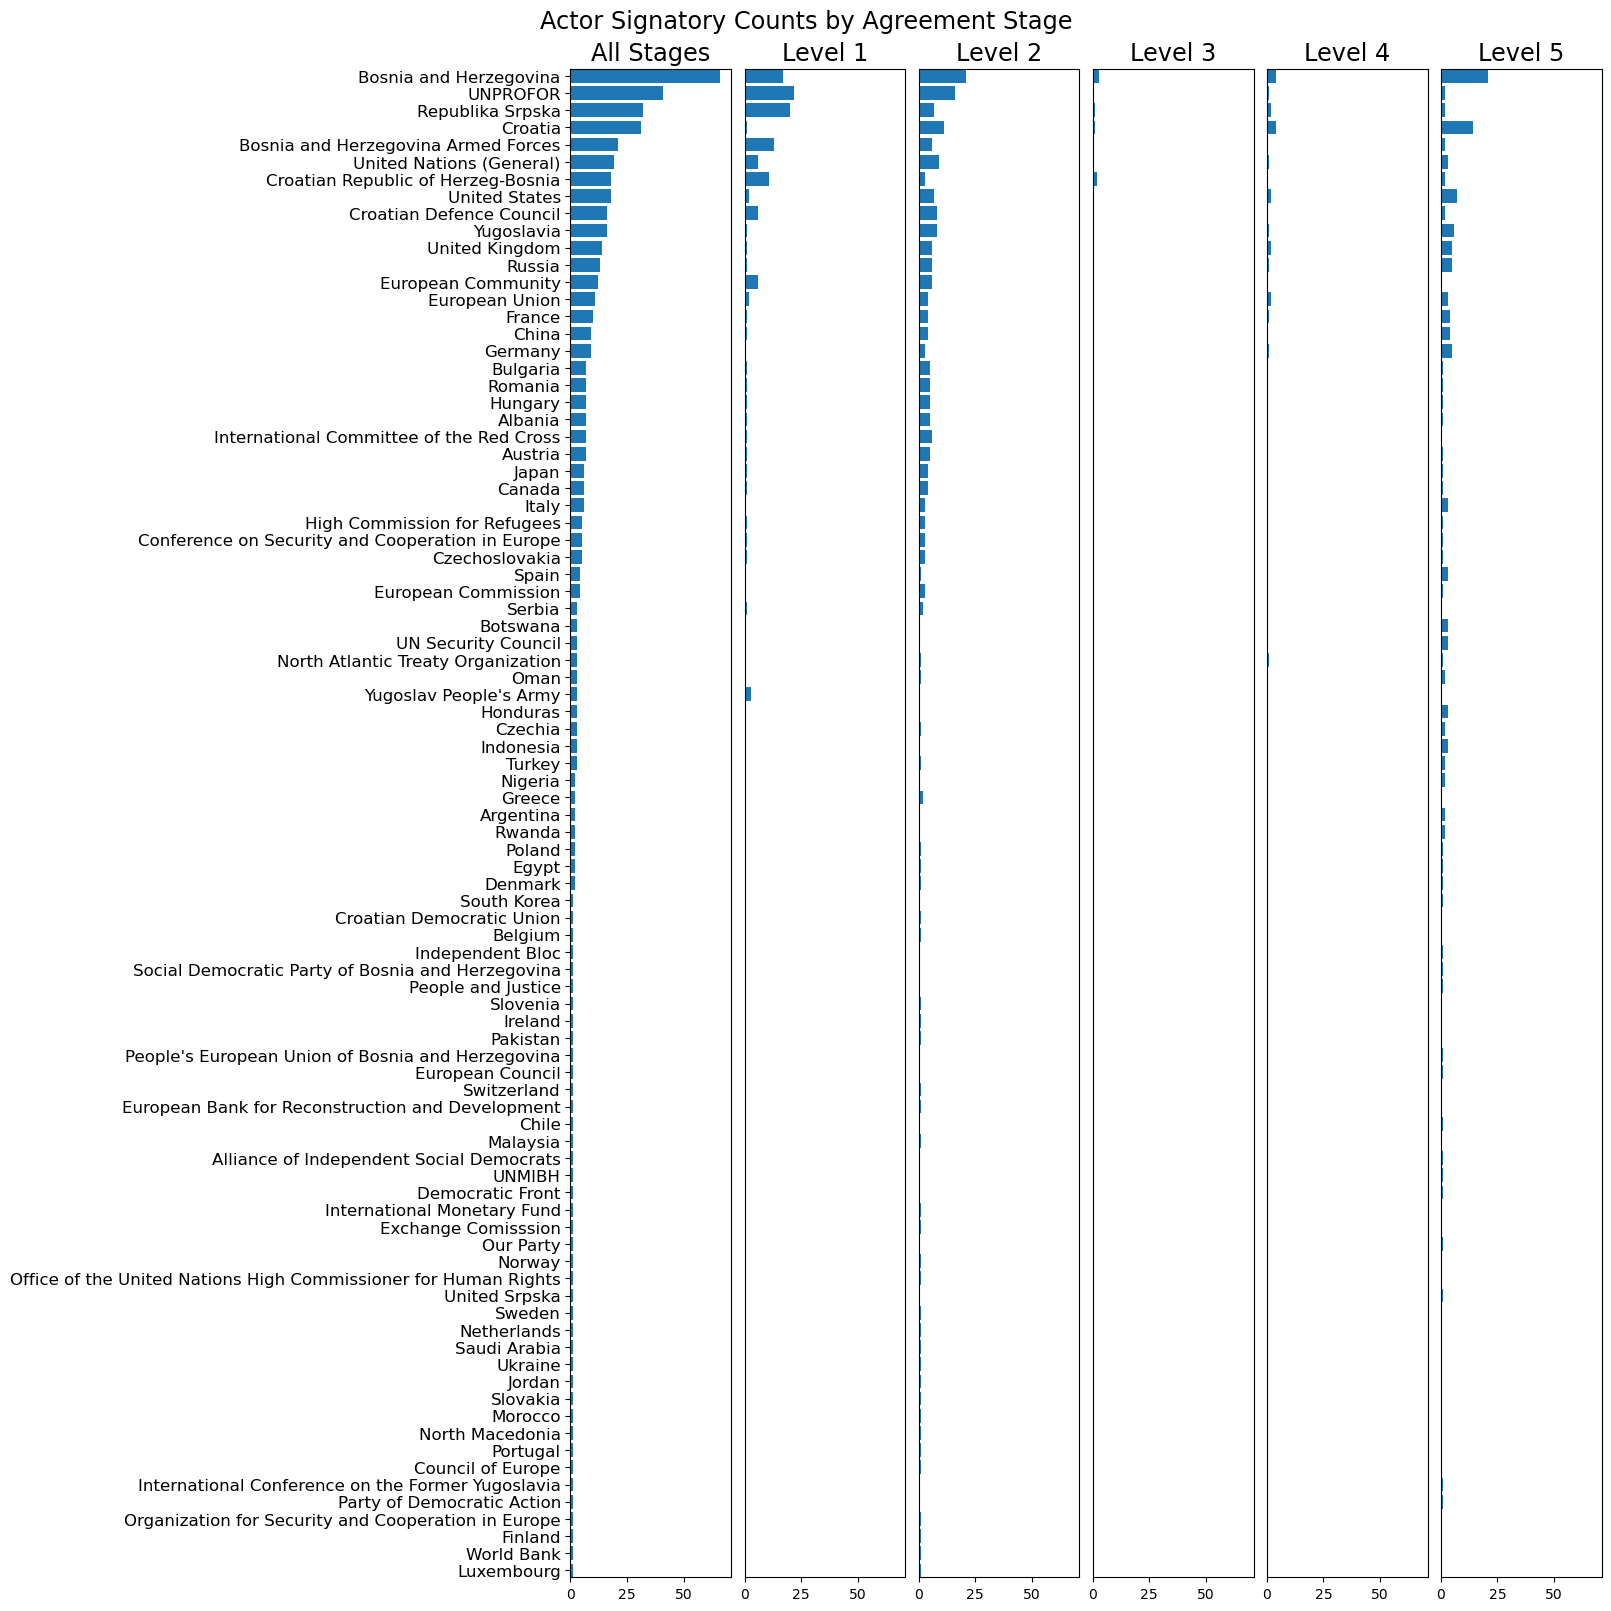

In [6]:
from matplotlib.gridspec import GridSpec


co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
values = [t[1] for t in z]
        
        
fig = plt.figure(figsize=(16,16),layout="constrained")

gs = GridSpec(1, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax1.barh(range(0,len(actor_diag)),values)
ax1.set_yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
ax1.set_xlim(0,max(values)+5)
ax1.margins(y=0)
ax1.set_title('All Stages',fontsize='xx-large')

print(z)
print()

stage_levels = [1,2,3,4,5]
for i,stage_level in enumerate(stage_levels):
    stage_agreement_indices = [k for k,v in stage_map.items() if v == stage_level]

    stage_matrix = pp_data_dict['pp_matrix'][np.ix_(stage_agreement_indices)]

    co_matrices = get_cooccurrence_matrices(stage_matrix)
    
    # Same order as all agreements so y-axes are consistent
    actor_diag = np.diag(co_matrices[0])
    x = list(zip(labels,actor_diag))
    x = sorted(x,key=lambda t:[g[0] for g in z].index(t[0]))
    print(x)
    print()
    
    ax = fig.add_subplot(gs[0,i+1])
    ax.barh(range(0,len(actor_diag)),[t[1] for t in x])

    ax.set_yticks([],[])
    ax.set_xlim(0,max(values)+5)
    ax.margins(y=0)
    ax.set_title('Level ' + str(stage_level),fontsize='xx-large')


fig.suptitle('Actor Signatory Counts by Agreement Stage',fontsize='xx-large')

plt.show()

88


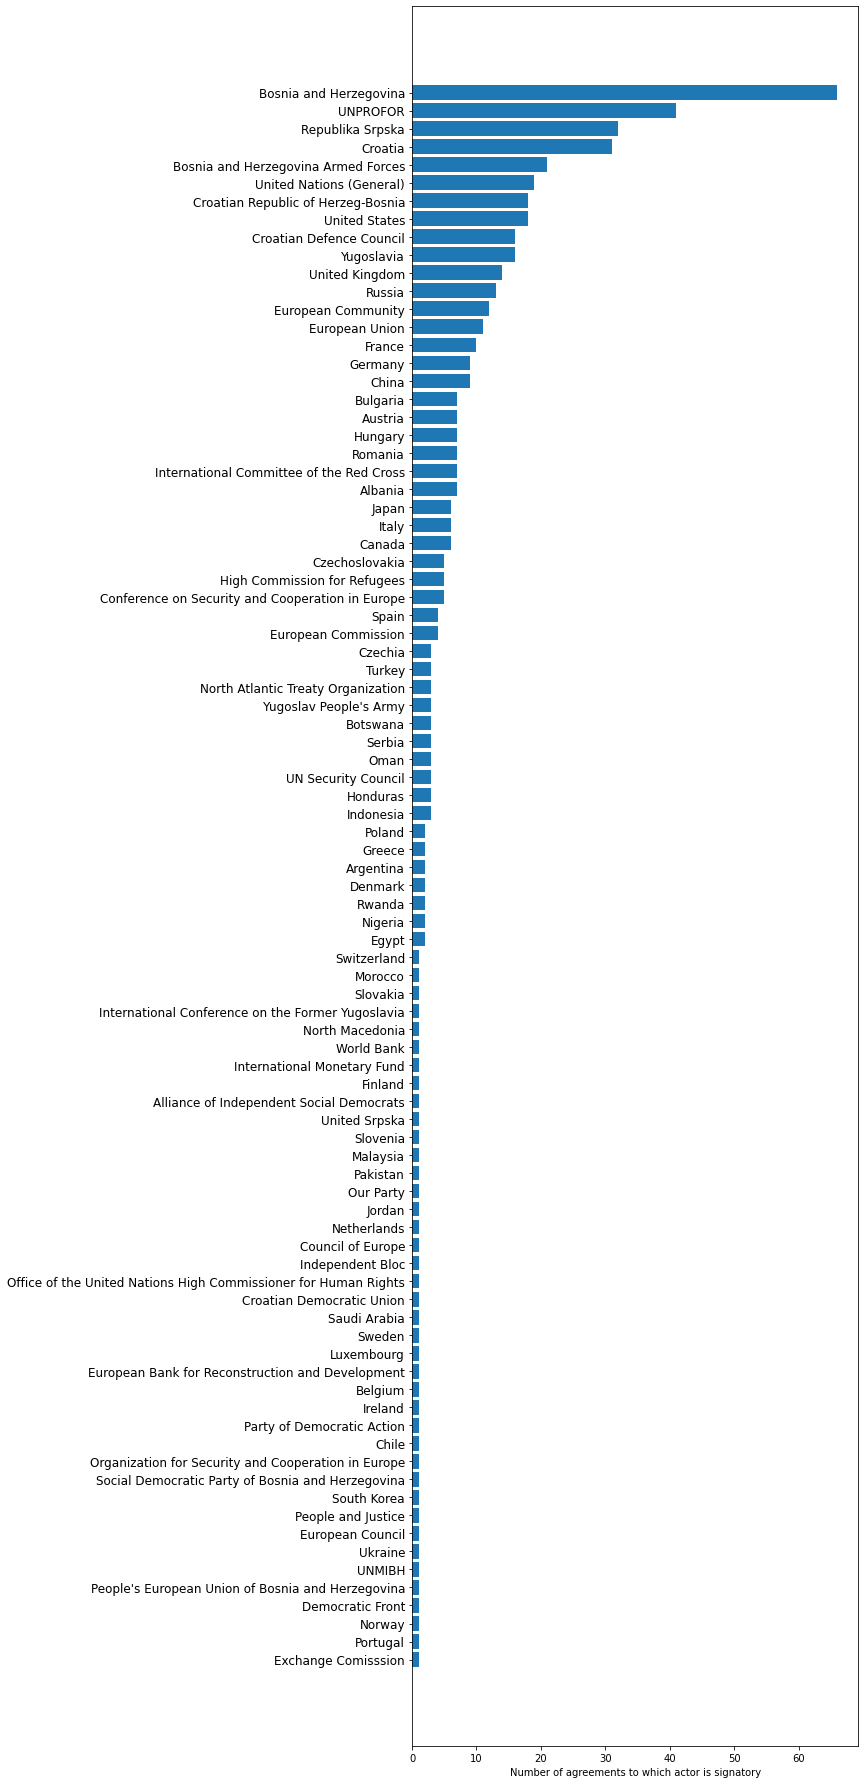

In [33]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
actor_diag = np.diag(co_matrices[0])

# Plot

labels = [data_dict['vertices_dict'][v][5] for v in pp_data_dict['pp_actor_ids']]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])
print(len(z))

f = plt.figure(figsize=(8,32))
plt.barh(range(0,len(actor_diag)),[t[1] for t in z])
plt.yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
plt.xlabel('Number of agreements to which actor is signatory')
plt.show()


## Retrieving co-occurrence entities

In [128]:
co_matrices = get_cooccurrence_matrices(pp_data_dict['pp_matrix'])
#print(list(co_matrices[0]))

# Find agreements that a pair of actors have in common

# Define indices for a pair of actors
row_index = 5
col_index = 8

# Get the row from the transpose of pp matrix
row = pp_data_dict['pp_matrix'].T[row_index]
# Get the row from the pp matrix
col = pp_data_dict['pp_matrix'].T[col_index]


x = np.bitwise_and(row,col)
print(len(x)) # The number of agreements

# Number in co-occurrence cell
print(co_matrices[0][row_index][col_index])

print(len([v for v in x if v == 1]))


120
0
0


## Build process-actor matrix

NameError: name 'matrix' is not defined

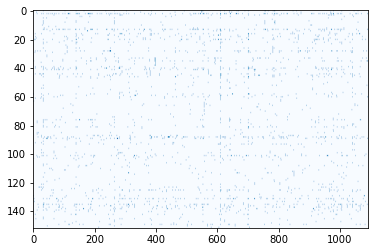

In [8]:
# Build a peace process-actor matrix

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)

# Get list of peace processes
processes = get_peace_processes(data_dict)


process_matrix = np.zeros((len(processes),len(data_dict['actor_vertices'])), dtype=int)

for i,process_name in enumerate(processes):
    process_data = get_peace_process_data(process_name,data_dict)
    actor_marginal = [sum(row) for row in process_data['pp_matrix'].T]
    actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in process_data['pp_actor_ids']]
    for j,v in enumerate(actor_marginal):
        if v > 0:
            process_matrix[i][actor_indices[j]] = 1

plt.imshow(process_matrix,cmap=plt.cm.Blues,aspect='auto')

proc_co = get_cooccurrence_matrices(process_matrix)



(1642, 1092)


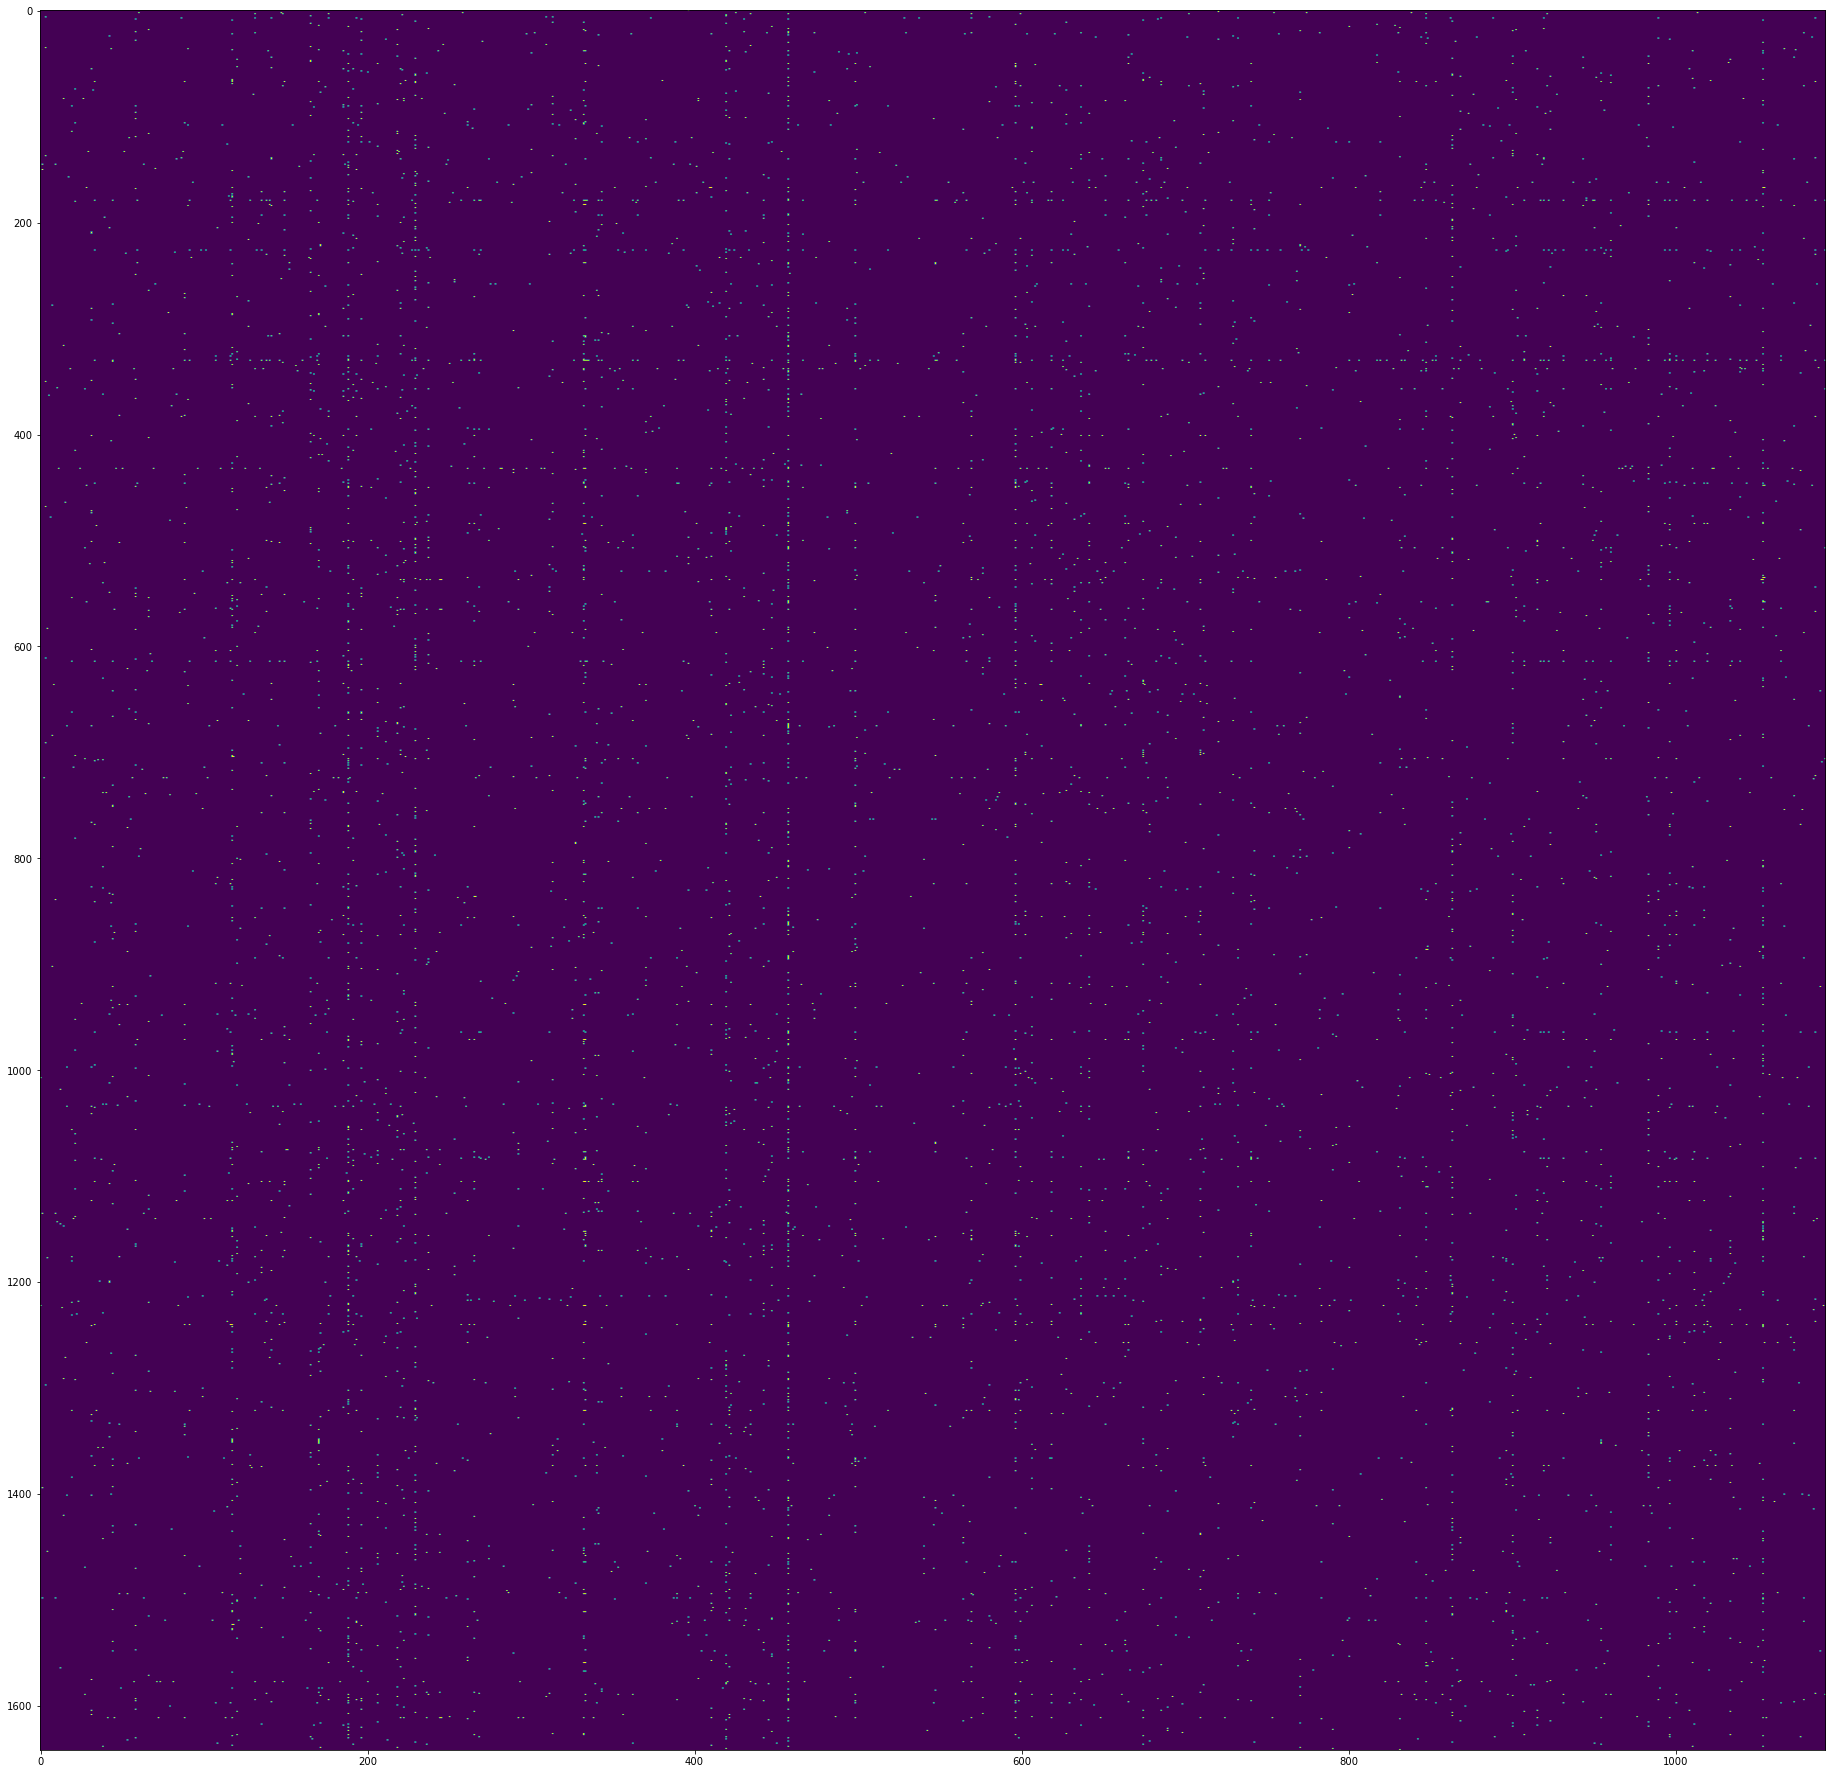

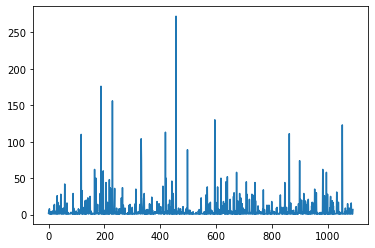

IGO_49 United Nations (General)


In [94]:


data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
matrix = data_dict['matrix']


# Matrix plot routines
print(matrix.shape)
f = plt.figure(figsize=(32,32))
plt.imshow(complete_matrix,aspect='auto')
plt.show()

# Get the column marginals
col_marginals = []
for row in complete_matrix.T:
    col_marginals.append(sum(row))


plt.plot(range(0,len(col_marginals)),col_marginals)
plt.show()

max_i = col_marginals.index(max(col_marginals))
max_actor = to_vertices[max_i]
print(max_actor,vertices_dict[max_actor][5])


In [96]:
x = np.argsort(col_marginals)[::-1][:5]
print("Indices:",x)


Indices: [ 457  188  229  596 1053]
